In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('bitcoin.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2713 non-null   object 
 1   Open       2713 non-null   float64
 2   High       2713 non-null   float64
 3   Low        2713 non-null   float64
 4   Close      2713 non-null   float64
 5   Adj Close  2713 non-null   float64
 6   Volume     2713 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 148.5+ KB


In [6]:
df.shape

(2713, 7)

In [7]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2.713000e+03
mean,11311.041069,11614.292482,10975.555057,11323.914637,11323.914637,1.470462e+10
std,16106.428891,16537.390649,15608.572560,16110.365010,16110.365010,2.001627e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,606.396973,609.260986,604.109985,606.718994,606.718994,7.991080e+07
50%,6301.569824,6434.617676,6214.220215,6317.609863,6317.609863,5.098183e+09
75%,10452.399414,10762.644531,10202.387695,10462.259766,10462.259766,2.456992e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


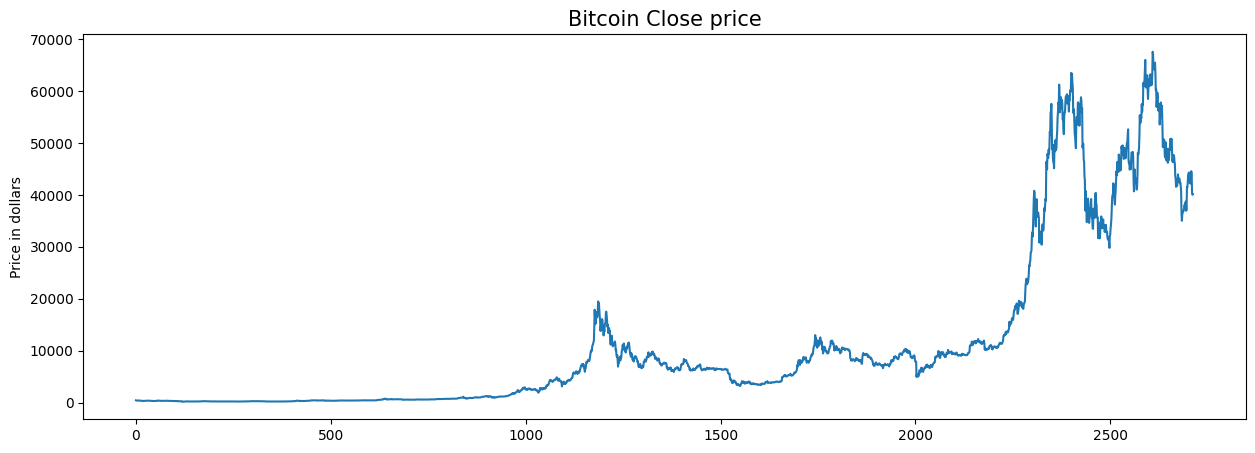

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(df['Close'])
plt.title('Bitcoin Close price', fontsize=15)
plt.ylabel('Price in dollars')
plt.show()

In [9]:
df[df['Close'] == df['Adj Close']].shape, df.shape

((2713, 7), (2713, 7))

In [10]:
df = df.drop(['Adj Close'], axis=1)

In [11]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

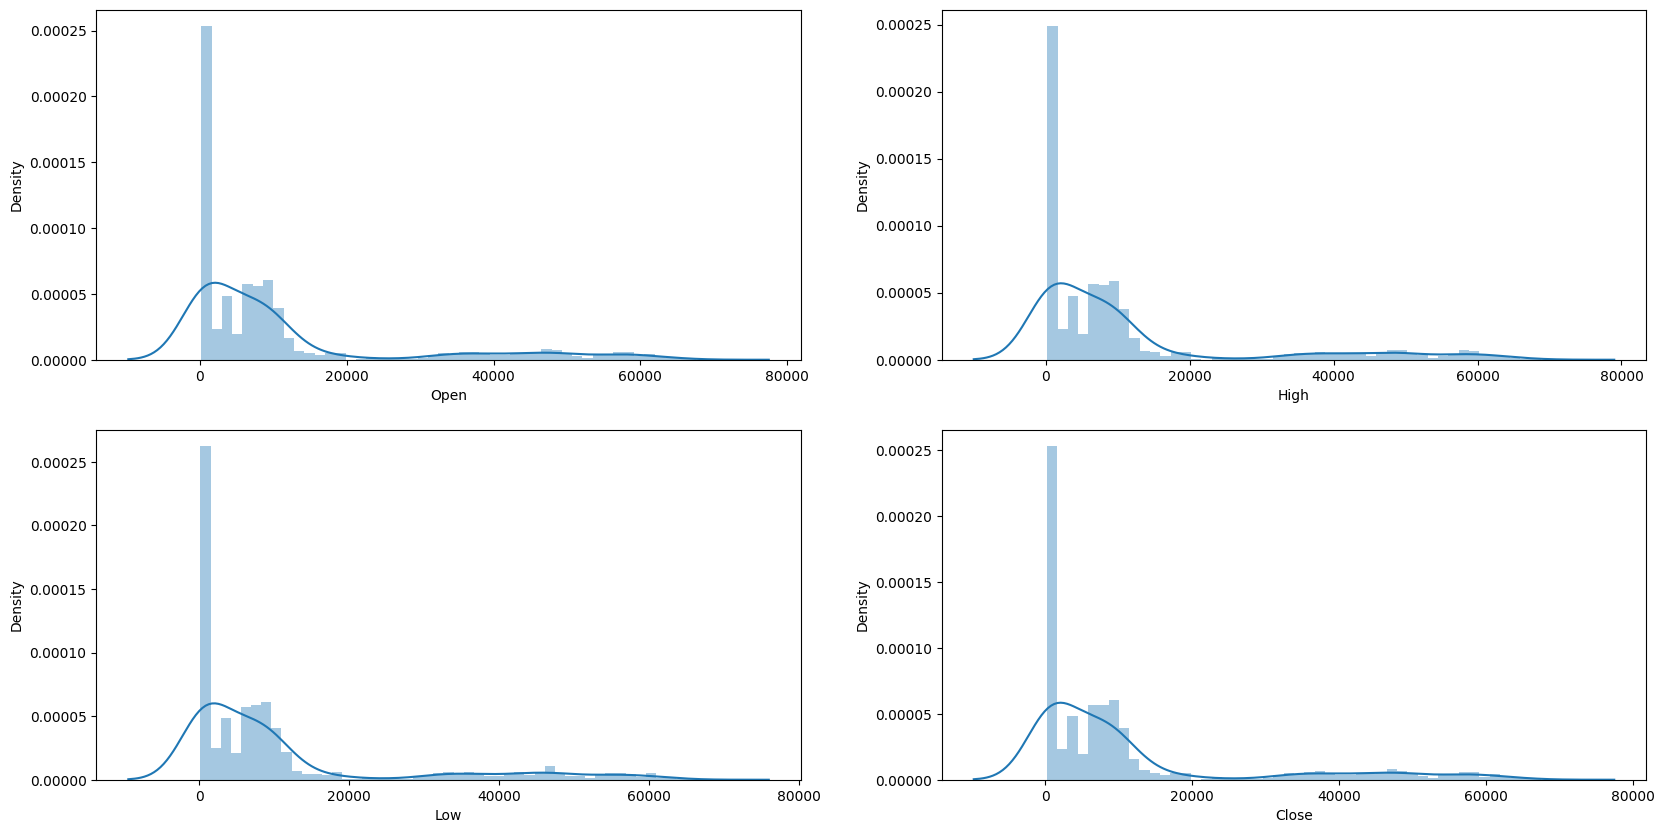

In [12]:
features = ['Open', 'High', 'Low', 'Close']

plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,2,i+1)
  sb.distplot(df[col])
plt.show()

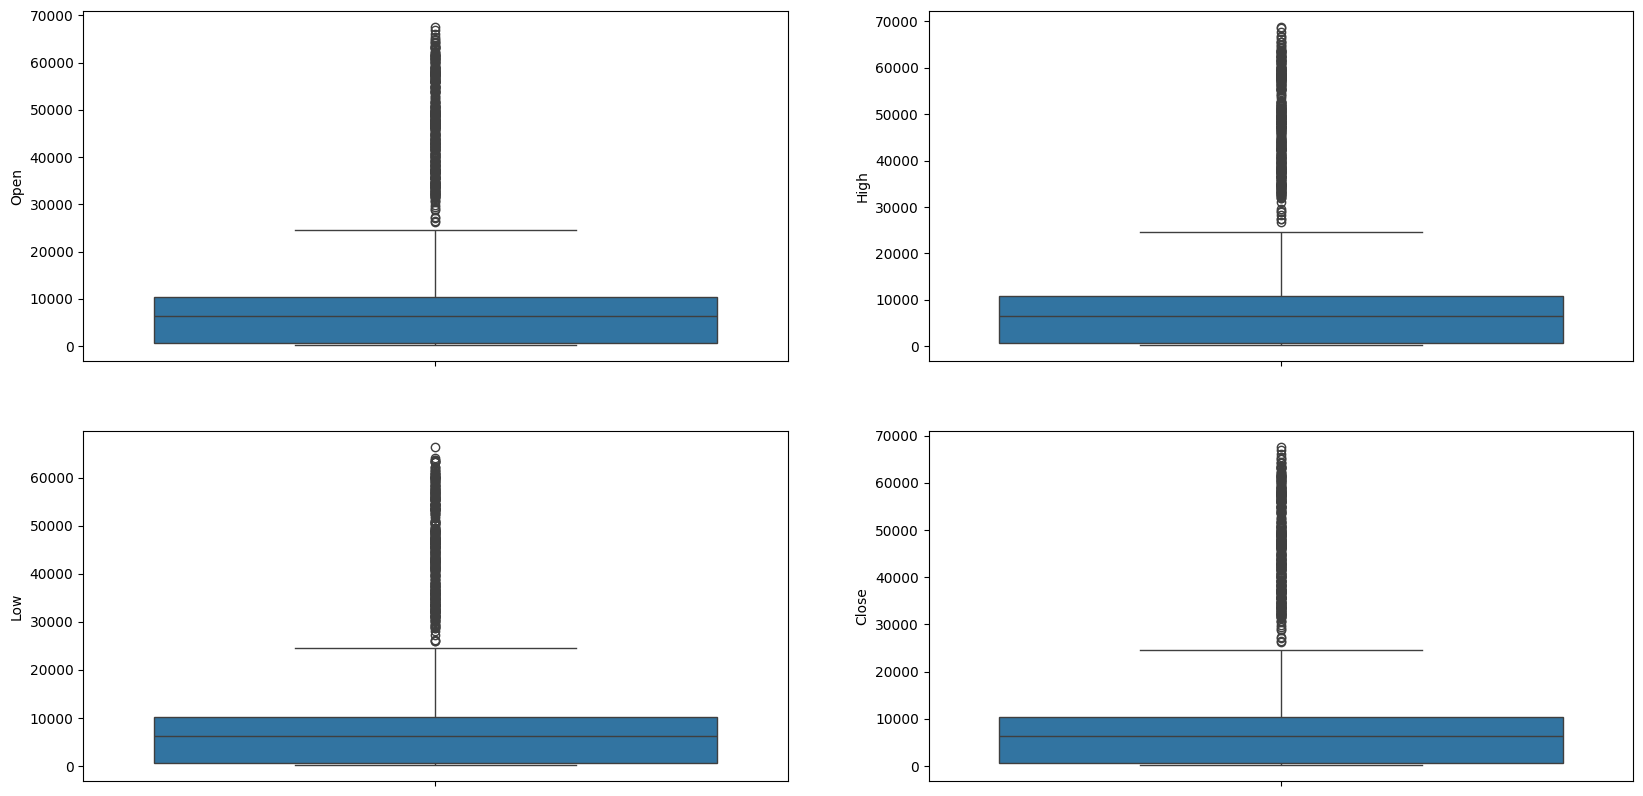

In [13]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,2,i+1)
  sb.boxplot(df[col])
plt.show()

In [14]:
splitted = df['Date'].str.split('-', expand=True)

df['year'] = splitted[0].astype('int')
df['month'] = splitted[1].astype('int')
df['day'] = splitted[2].astype('int')

df.head()

,Date,Open,High,Low,Close,Volume,year,month,day
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21


In [15]:
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.head()

,Date,Open,High,Low,Close,Volume,year,month,day,is_quarter_end
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17,1
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18,1
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19,1
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20,1
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21,1


In [16]:
df['open-close'] = df['Open'] - df['Close']
df['low-high'] = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

df.head()

,Date,Open,High,Low,Close,Volume,year,month,day,is_quarter_end,open-close,low-high,target
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17,1,8.529999,-15.752014,0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18,1,32.419983,-43.755981,0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19,1,29.307007,-43.302978,1
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20,1,-14.230988,-33.412994,0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21,1,9.263977,-19.244995,1


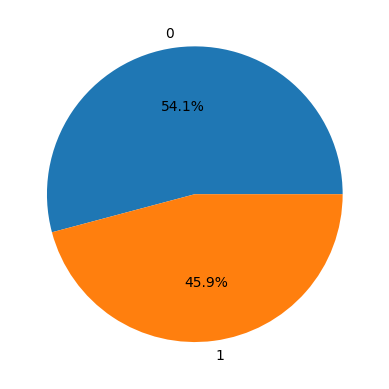

In [17]:
plt.pie(df['target'].value_counts().values,
		labels=[0, 1], autopct='%1.1f%%')
plt.show()

In [18]:
df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')
del df['Date']
df.head()

,Open,High,Low,Close,Volume,year,month,day,is_quarter_end,open-close,low-high,target
Date,,,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17,1,8.529999,-15.752014,0
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18,1,32.419983,-43.755981,0
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19,1,29.307007,-43.302978,1
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20,1,-14.230988,-33.412994,0
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21,1,9.263977,-19.244995,1


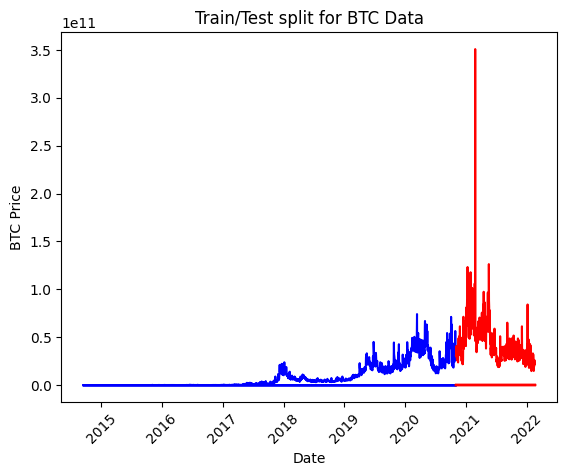

In [19]:
train = df[df.index < pd.to_datetime("2020-11-01", format='%Y-%m-%d')]
test = df[df.index > pd.to_datetime("2020-11-01", format='%Y-%m-%d')]

plt.plot(train, color = "blue")
plt.plot(test, color = "red")
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.show()

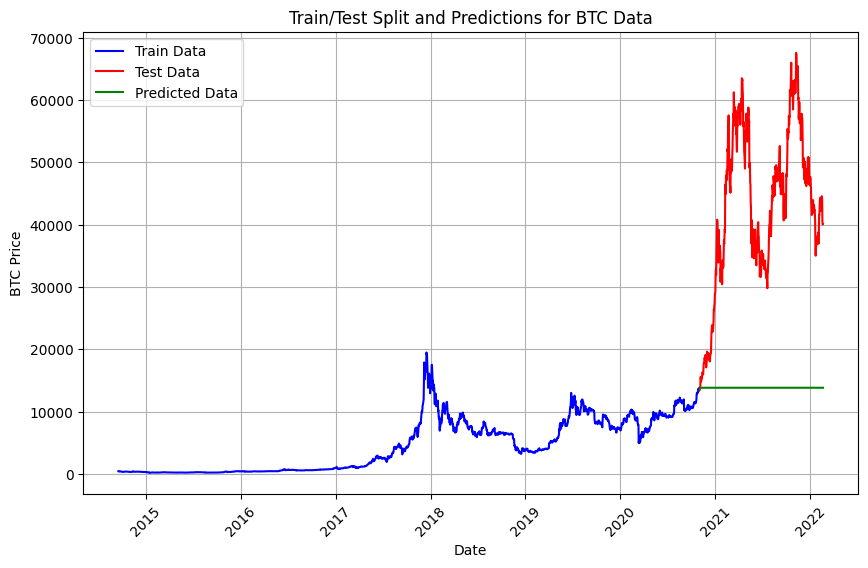

In [37]:
order = (5,1,0)
model = ARIMA(train['Close'], order=order)
fit_model = model.fit()

predicted_values = fit_model.forecast(steps=len(test))

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Close'], color="blue", label="Train Data")
plt.plot(test.index, test['Close'], color="red", label="Test Data")
plt.plot(test.index, predicted_values, color="green", label="Predicted Data")
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Train/Test Split and Predictions for BTC Data')
plt.legend()
plt.grid(True)
plt.show()